In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import deque
import random
import pandas as pd
import numpy as np
import torch.optim as optim

In [2]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining network to optimize our Q function
        self.input = nn.Linear(30,40)
        self.out = nn.Linear(40, 3)
    ## Forward propagation
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.out(x)
     
        return x
    ## Train model
    def train(self,X,Y):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        running_loss = 0.0
        for i in range(len(X)):
            inputs, labels= torch.FloatTensor(X[i]), torch.FloatTensor(Y[i])
            optimizer.zero_grad()
            out = self(inputs)
            loss = criterion(out, torch.FloatTensor(Y[i]))
            loss.backward()          ## This does back propagation
            optimizer.step()         ## To optimize loss function 
            running_loss+=loss.item()  ## the value of the loss function after training
        
        return running_loss
    
    

In [3]:
class Agent:
    def __init__(self, state_size,window_size,trend, skip,batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.model = DQN()
    def act(self,state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return torch.argmax(self.model(torch.FloatTensor(state)))
    
    def get_state(self,t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def replay(self,batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l-batch_size,l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model(torch.FloatTensor(states)).tolist()
        Q_new = self.model(torch.FloatTensor(new_states)).tolist()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            
            if not done:
                target[action] += self.gamma * max(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train(X,Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)    
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))               
                

In [4]:
df = pd.read_csv('./GOOG-year.csv')
df.head()
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

In [5]:
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)
    
    

epoch: 10, total rewards: 1452.189522.3, cost: 0.867242, total money: 11452.189522
epoch: 20, total rewards: 16.039977.3, cost: 0.233438, total money: 10016.039977
epoch: 30, total rewards: -18.540039.3, cost: 0.234539, total money: 9981.459961
epoch: 40, total rewards: -13.029968.3, cost: 0.579243, total money: 9986.970032
epoch: 50, total rewards: 1.300049.3, cost: 2.201249, total money: 10001.300049
epoch: 60, total rewards: 5.749939.3, cost: 1.103594, total money: 10005.749939
epoch: 70, total rewards: -2.359985.3, cost: 2.503666, total money: 9997.640015
epoch: 80, total rewards: 19.379943.3, cost: 1.553169, total money: 10019.379943
epoch: 90, total rewards: -27.279969.3, cost: 0.332722, total money: 9972.720031
epoch: 100, total rewards: 42.325073.3, cost: 4.685036, total money: 10042.325073


In [6]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 16: buy 1 unit at price 761.679993, total balance 9238.320007
day 17, sell 1 unit at price 768.239990, investment 0.861254 %, total balance 10006.559997,
day 40: buy 1 unit at price 771.820007, total balance 9234.739990
day 41, sell 1 unit at price 786.140015, investment 1.855356 %, total balance 10020.880005,
day 59: buy 1 unit at price 802.320007, total balance 9218.559998
day 60, sell 1 unit at price 796.789978, investment -0.689255 %, total balance 10015.349976,
day 110: buy 1 unit at price 824.320007, total balance 9191.029969
day 111, sell 1 unit at price 823.559998, investment -0.092198 %, total balance 10014.589967,
day 155: buy 1 unit at price 939.780029, total balance 9074.809938
day 157, sell 1 unit at price 950.630005, investment 1.154523 %, total balance 10025.439943,
day 159: buy 1 unit at price 957.090027, total balance 9068.349916
day 160, sell 1 unit at price 965.590027, investment 0.888109 %, total balance 10033.939943,
day 164: buy 1 unit at price 917.789978, tot

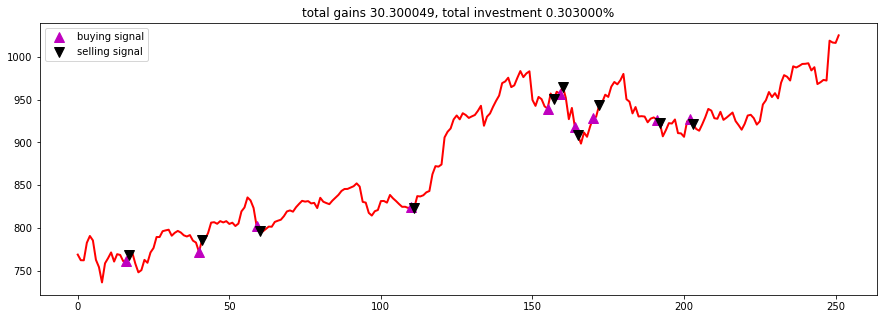

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()